In [130]:
#importing everything we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error,r2_score,plot_confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [131]:
df=pd.DataFrame(pd.read_csv("/kaggle/input/cancerprediction/EXAM_8/data.csv")) #loading dataset
df = df[df['Patient\'s Vital Status'].notna()] #selecting only rows that have y label
df.drop(["Patient ID"],inplace=True,axis=1) #dropping patient id because it's useless

#selecting categorical data
cat_data=['Type of Breast Surgery', 'Overall Survival Status', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC', 'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'PR Status', 'Oncotree Code', 'Radio Therapy', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype','Cohort','Tumor Stage','Neoplasm Histologic Grade'] 
dist=df.drop(cat_data+['Patient\'s Vital Status'],axis=1)
#one-hot encoding categorical data
df=pd.concat((pd.get_dummies(df.iloc[:,:-1],drop_first=True,columns=cat_data),df['Patient\'s Vital Status']),axis=1)


In [132]:
#label encoding of y data
le = LabelEncoder()
df['Patient\'s Vital Status'] = le.fit_transform(df['Patient\'s Vital Status'].values)
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)

{'Died of Disease': 0, 'Died of Other Causes': 1, 'Living': 2}


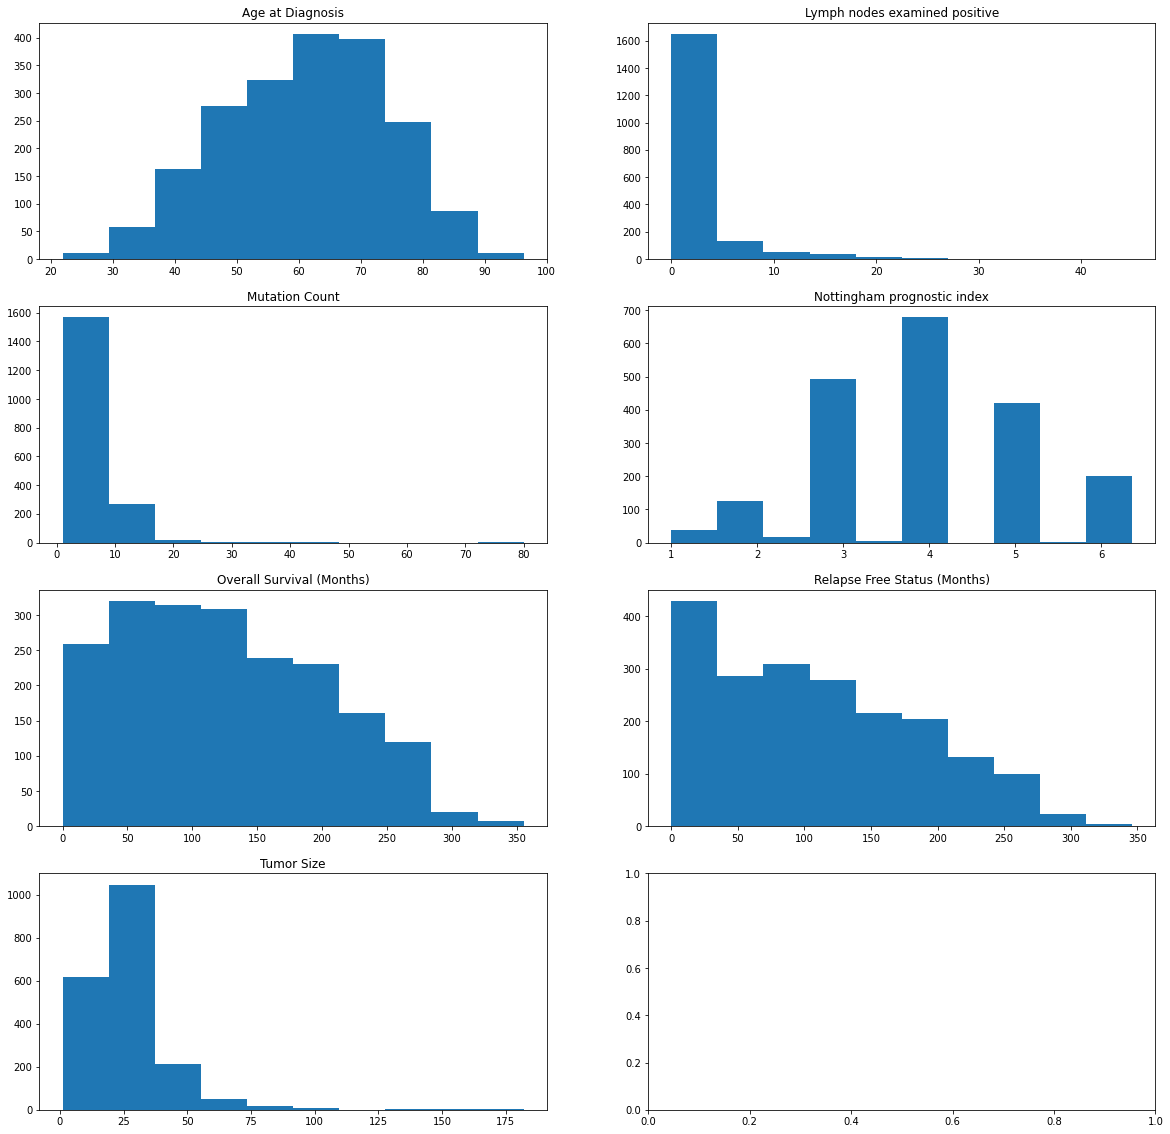

In [133]:
#checking continuous data's distribution type
f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx==7:
        break
    ax.hist(df[dist.keys()[idx]])
    ax.set_title(dist.keys()[idx])
plt.gcf().set_size_inches(20, 20)

In [134]:
#standardisation and normalisation 

scaler = MinMaxScaler()

df.iloc[:,1:3] = scaler.fit_transform(df.iloc[:,1:3])
df.iloc[:,4:7] = scaler.fit_transform(df.iloc[:,4:7])

#because age and nottingam prognostic index's distribution look like gausian we use sandartisation,
#for other continuous columns we use normalisation (minMaxScaler)
scaler = StandardScaler()

df.iloc[:,0] = scaler.fit_transform(df.iloc[:,0].values.reshape(-1, 1))
df.iloc[:,3] = scaler.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

df.head()


,Age at Diagnosis,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Tumor Size,Type of Breast Surgery_Mastectomy,Overall Survival Status_Living,Cancer Type_Breast Sarcoma,...,Cohort_3.0,Cohort_4.0,Cohort_5.0,Tumor Stage_1.0,Tumor Stage_2.0,Tumor Stage_3.0,Tumor Stage_4.0,Neoplasm Histologic Grade_2.0,Neoplasm Histologic Grade_3.0,Patient's Vital Status
0,1.124496,0.222222,NaN,1.748863,0.395552,0.400283,0.116022,1,1,0,...,0,0,0,0,1,0,0,0,1,2
1,-1.382147,0.000000,0.012658,0.007784,0.238270,0.241122,0.049724,0,1,0,...,0,0,0,1,0,0,0,0,1,2
2,-0.943523,0.022222,0.012658,0.016386,0.460867,0.436746,0.077348,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,-1.035418,0.066667,0.000000,0.033591,0.464339,0.469889,0.132597,1,1,0,...,0,0,0,0,1,0,0,1,0,2
4,1.226430,0.177778,0.012658,1.779831,0.116460,0.053554,0.215470,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [135]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [154]:
#because nan can negatively impact our model performance we use KNN imputer to "repair" data 
#and the we fit it into RFC model
pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=100)), ('m', RandomForestClassifier(n_estimators=1000))])

In [155]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('i', KNNImputer(n_neighbors=100)),
                ('m', RandomForestClassifier(n_estimators=1000))])

In [156]:
res = pipeline.predict(X_test)
print(mean_absolute_error(y_test, res))

0.02861952861952862



                      precision    recall  f1-score   support

     Died of Disease       0.92      1.00      0.96       183
Died of Other Causes       1.00      0.89      0.94       153
              Living       1.00      1.00      1.00       258

            accuracy                           0.97       594
           macro avg       0.97      0.96      0.97       594
        weighted avg       0.97      0.97      0.97       594



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


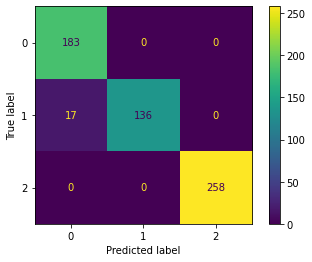

In [157]:
from sklearn.metrics import classification_report
import pandas as pd
y_pred = pipeline.predict(X_test)
print("\n"+ classification_report(y_test, y_pred,target_names=['Died of Disease', 'Died of Other Causes', 'Living']))
plot_confusion_matrix(pipeline, X_test, y_test)